In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
from keras.applications.xception import Xception

conv_base = Xception(weights='imagenet',
                     include_top=False,
                     input_shape=(299, 299, 3))

In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 10, 10, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 10, 10, 2048))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 12500 images belonging to 1 classes.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (20000, 10 * 10 * 2048))
validation_features = np.reshape(validation_features, (5000, 10 * 10 * 2048))
test_features = np.reshape(test_features, (12500, 10 * 10 * 2048))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_dim=10 * 10 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [8]:
history = model.fit(train_features, train_labels,
                    epochs=10,
                    batch_size=50,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 597s 30ms/step - loss: 0.0468 - acc: 0.9891 - val_loss: 0.0503 - val_acc: 0.9918
Epoch 2/10
20000/20000 [==============================] - 653s 33ms/step - loss: 0.0277 - acc: 0.9953 - val_loss: 0.0500 - val_acc: 0.9932
Epoch 3/10
20000/20000 [==============================] - 616s 31ms/step - loss: 0.0190 - acc: 0.9967 - val_loss: 0.0704 - val_acc: 0.9928
Epoch 4/10
20000/20000 [==============================] - 757s 38ms/step - loss: 0.0137 - acc: 0.9980 - val_loss: 0.0676 - val_acc: 0.9936
Epoch 5/10
20000/20000 [==============================] - 650s 32ms/step - loss: 0.0101 - acc: 0.9981 - val_loss: 0.0664 - val_acc: 0.9934
Epoch 6/10
20000/20000 [==============================] - 752s 38ms/step - loss: 0.0088 - acc: 0.9988 - val_loss: 0.0782 - val_acc: 0.9914
Epoch 7/10
20000/20000 [==============================] - 677s 34ms/step - loss: 0.0065 - acc: 0.9992 - val_loss: 0.0

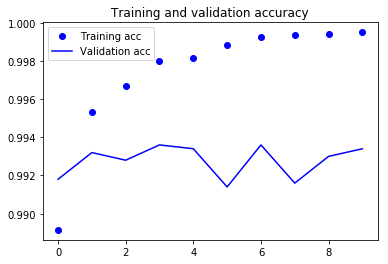

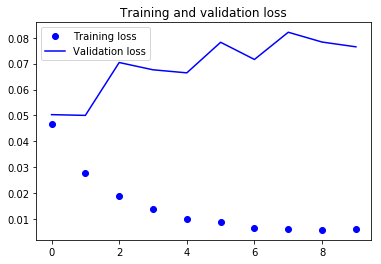

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
from keras.preprocessing import image
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import backend as K

x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=predictions)

In [13]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 158


In [14]:
for layer in conv_base.layers:
    layer.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(299, 299),
        batch_size=50,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=50,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [16]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=100,
      verbose=2)

Epoch 1/30
 - 505s - loss: 0.2152 - acc: 0.9440 - val_loss: 0.0976 - val_acc: 0.9744
Epoch 2/30
 - 461s - loss: 0.0929 - acc: 0.9685 - val_loss: 0.0812 - val_acc: 0.9766
Epoch 3/30
 - 460s - loss: 0.0812 - acc: 0.9703 - val_loss: 0.0681 - val_acc: 0.9788
Epoch 4/30
 - 460s - loss: 0.0802 - acc: 0.9697 - val_loss: 0.0867 - val_acc: 0.9740
Epoch 5/30
 - 463s - loss: 0.0774 - acc: 0.9697 - val_loss: 0.0808 - val_acc: 0.9760
Epoch 6/30
 - 458s - loss: 0.0755 - acc: 0.9708 - val_loss: 0.0644 - val_acc: 0.9808
Epoch 7/30
 - 457s - loss: 0.0760 - acc: 0.9716 - val_loss: 0.0726 - val_acc: 0.9786
Epoch 8/30
 - 458s - loss: 0.0737 - acc: 0.9717 - val_loss: 0.0794 - val_acc: 0.9772
Epoch 9/30
 - 458s - loss: 0.0686 - acc: 0.9740 - val_loss: 0.0787 - val_acc: 0.9766
Epoch 10/30
 - 459s - loss: 0.0723 - acc: 0.9722 - val_loss: 0.0678 - val_acc: 0.9794
Epoch 11/30
 - 459s - loss: 0.0690 - acc: 0.9742 - val_loss: 0.1027 - val_acc: 0.9700
Epoch 12/30
 - 458s - loss: 0.0686 - acc: 0.9729 - val_loss: 0.

In [17]:
model.save('Xception_feature_extraction.h5')

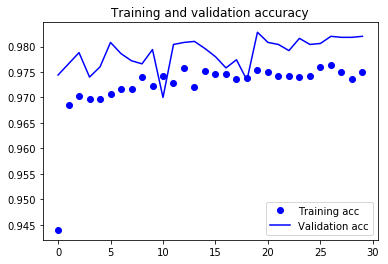

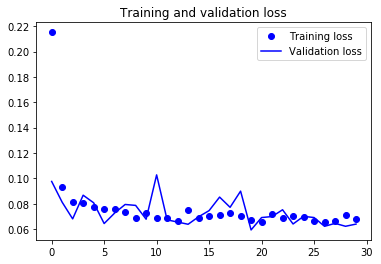

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

add_4 (Add)                     (None, 19, 19, 728)  0           block5_sepconv3_bn[0][0]         
                                                                 add_3[0][0]                      
__________________________________________________________________________________________________
block6_sepconv1_act (Activation (None, 19, 19, 728)  0           add_4[0][0]                      
__________________________________________________________________________________________________
block6_sepconv1 (SeparableConv2 (None, 19, 19, 728)  536536      block6_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block6_sepconv1_bn (BatchNormal (None, 19, 19, 728)  2912        block6_sepconv1[0][0]            
__________________________________________________________________________________________________
block6_sepconv2_act (Activation (None, 19, 19, 728)  0           block6_sepconv1_bn[0][0]         
__________

block10_sepconv1_bn (BatchNorma (None, 19, 19, 728)  2912        block10_sepconv1[0][0]           
__________________________________________________________________________________________________
block10_sepconv2_act (Activatio (None, 19, 19, 728)  0           block10_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block10_sepconv2 (SeparableConv (None, 19, 19, 728)  536536      block10_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block10_sepconv2_bn (BatchNorma (None, 19, 19, 728)  2912        block10_sepconv2[0][0]           
__________________________________________________________________________________________________
block10_sepconv3_act (Activatio (None, 19, 19, 728)  0           block10_sepconv2_bn[0][0]        
__________________________________________________________________________________________________
block10_se

In [20]:
for layer in model.layers[:126]:
    layer.trainable = False
for layer in model.layers[126:]:
    layer.trainable = True

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=100)

Epoch 1/100
400/400 [==============================] - 479s 1s/step - loss: 0.0645 - acc: 0.9748 - val_loss: 0.0289 - val_acc: 0.9918
Epoch 2/100
400/400 [==============================] - 470s 1s/step - loss: 0.0598 - acc: 0.9767 - val_loss: 0.0280 - val_acc: 0.9918
Epoch 3/100
400/400 [==============================] - 467s 1s/step - loss: 0.0568 - acc: 0.9774 - val_loss: 0.0296 - val_acc: 0.9910
Epoch 4/100
400/400 [==============================] - 470s 1s/step - loss: 0.0552 - acc: 0.9796 - val_loss: 0.0312 - val_acc: 0.9906
Epoch 5/100
400/400 [==============================] - 463s 1s/step - loss: 0.0519 - acc: 0.9811 - val_loss: 0.0290 - val_acc: 0.9912
Epoch 6/100
400/400 [==============================] - 471s 1s/step - loss: 0.0506 - acc: 0.9804 - val_loss: 0.0314 - val_acc: 0.9906
Epoch 7/100
400/400 [==============================] - 475s 1s/step - loss: 0.0474 - acc: 0.9823 - val_loss: 0.0317 - val_acc: 0.9908
Epoch 8/100
400/400 [==============================] - 473s 1s

Epoch 62/100
400/400 [==============================] - 473s 1s/step - loss: 0.0191 - acc: 0.9934 - val_loss: 0.0349 - val_acc: 0.9916
Epoch 63/100
400/400 [==============================] - 471s 1s/step - loss: 0.0205 - acc: 0.9922 - val_loss: 0.0361 - val_acc: 0.9916
Epoch 64/100
400/400 [==============================] - 479s 1s/step - loss: 0.0196 - acc: 0.9934 - val_loss: 0.0352 - val_acc: 0.9918
Epoch 65/100
400/400 [==============================] - 469s 1s/step - loss: 0.0198 - acc: 0.9933 - val_loss: 0.0353 - val_acc: 0.9916
Epoch 66/100
400/400 [==============================] - 483s 1s/step - loss: 0.0164 - acc: 0.9939 - val_loss: 0.0356 - val_acc: 0.9916
Epoch 67/100
400/400 [==============================] - 478s 1s/step - loss: 0.0231 - acc: 0.9914 - val_loss: 0.0371 - val_acc: 0.9916
Epoch 68/100
400/400 [==============================] - 474s 1s/step - loss: 0.0218 - acc: 0.9925 - val_loss: 0.0373 - val_acc: 0.9914
Epoch 69/100
400/400 [==============================] -

In [22]:
model.save('Xception_Finetuning.h5')

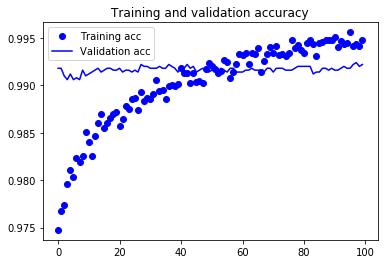

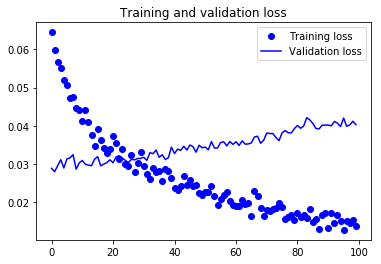

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

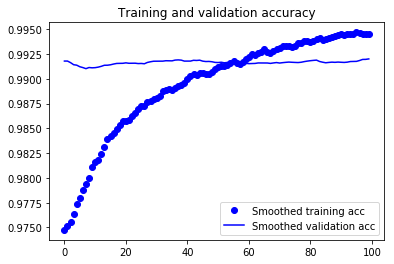

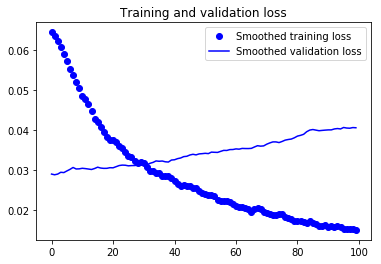

In [24]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()